# UMA GTFS EDA

In [36]:
!pip install unidecode

     |████████████████████████████████| 241 kB 1.8 MB/s eta 0:00:01


## Import Libraries

In [2]:
# analysis
import numpy as np
import pandas as pd
import json
import geopandas as gpd
import gtfs_functions
import gtfs_kit

# other
import warnings
import os
import requests
from time import sleep

# visualisation libraries
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
import seaborn as sns

# Notebook styling
%matplotlib inline
sns.set(style='whitegrid', palette='muted',
        rc={'figure.figsize': (15,10)})
warnings.filterwarnings("ignore")


In [3]:
def get_api_token(credentials_file_loc):
    
    """
    This function makes a POST request to Gometro's UMA REST API and returns a valid api token
    
    ------------------------------------
    Parameters:
        credentials_file_loc (str): 
        date (str): column name of field containing the payload of the data
    
    Returns: (str): 
    
    ------------------------------------
    
    Example:
      
    
    """
    
    # get dictionary of authorisation credentials
    with open(credentials_file_loc , "r") as read_file:
        task = json.load(read_file)
    
    # make api request
    endpoint = 'https://identity.gometroapp.com/auth/realms/platform/protocol/openid-connect/token'
    response = requests.post(endpoint, data=task)
    
    # catch error
    if (response.status_code < 200) and (response.status_code >= 300):
        raise ValueError('POST /tasks/ {}'.format(response.status_code))
    
    return response.json()["access_token"]
    
    

In [4]:
def get_uma_events(pid, date, token, print_json=False):
    
    """
    This function makes a GET request to Gometro's UMA REST API and returns all
    events from the API.
    
    ------------------------------------
    Parameters:
        participant_id (str): column name of field containing the payload of the data
        date (str): column name of field containing the payload of the data
    
    Returns: (pandas.DataFrame): Dataframe with payload data in each column
    ------------------------------------
    Example:
    
    
    
    """
    
    # define API headers
    headers = {'Authorization': f'Bearer {token}'}
    
    # make api request    
    endpoint = f'https://api.gometroapp.com/uma/v1/participants/{pid}/events/{date}'
    response = requests.get(endpoint, headers=headers)
    
    # raise bad response error
    if (response.status_code < 200) and (response.status_code >= 300):
        raise ValueError('GET /tasks/ {}'.format(response.status_code))
    
    # raise timeout error
    if response.json() == {'message': 'Endpoint request timed out'}:
        raise TimeoutError(response.json()['message'])
    
    # raise no data error
    assert len(response.json()) > 0, "response returned no data"
    
    # print raw file for debugging
    if print_json == True:
        print(response.json())
    
    return pd.DataFrame(response.json())

    

In [5]:
def get_raw_user_data(pid, token, date, print_json=False):
    
    """
    This function makes a GET request to Gometro's UMA REST API and returns data from
    the API.
    
    ------------------------------------
    Parameters:
        participant_id (str): column name of field containing the payload of the data
        date (str): column name of field containing the payload of the data
    
    Returns: (pandas.DataFrame): Dataframe with payload data in each column
    ------------------------------------
    Example:
    
    
    
    """
    
#     # define API headers
#     headers = {'Authorization': f'Bearer {token}'}
    
#     # make api request
#     endpoint = f'https://api.gometroapp.com/uma/v1/participants/{pid}/events/{date}'
    
#     response = requests.get(endpoint, headers=headers)
    
#     # catch request error
#     if (response.status_code < 200) and (response.status_code >= 300):
#         raise ValueError('GET /tasks/ {}'.format(response.status_code))
    
#     # ensure json is not empty
#     assert len(response.json()) > 0, "response returned no data"
    
#     # print raw file for debugging
#     if print_json == True:
#         print(response.json())
    
    # import data
    df = get_uma_events(pid, date, token, print_json=print_json)
    
    # select location data
    return df[df['type'] == 'LocationChanged']


In [6]:
def get_all_participant_trips(pid, token, print_json=False):
    
    """
    This function makes a GET request to Gometro's UMA REST API and returns data from
    the API.
    
    ------------------------------------
    Parameters:
        pid (str): 
        startdate (str): 
        enddate (str): 
        token (str): 
        
    
    Returns: (pandas.DataFrame):
        Dataframe with the respose of requested trip data
    ------------------------------------
    Example:
    
    
    
    """
    
    # define API headers
    headers = {'Authorization': f'Bearer {token}'}
    
    # make api request
    endpoint = f'https://api.gometroapp.com/uma/v1/participants/{pid}/trips?'
    response = requests.get(endpoint, headers=headers)
    
    # catch resquest error
    if (response.status_code < 200) and (response.status_code >= 300):
        raise ValueError('GET /tasks/ {}'.format(response.status_code))
    
    # ensure json is not empty
    assert len(response.json()) > 0, "response returned no data"
    
    # print raw file for debugging
    if print_json == True:
        print(response.json())
    
    # import data
    return pd.DataFrame(response.json())

In [7]:
def get_trip_ref_data(pid, startdate, enddate, token):
    
    """
    This function makes a GET request to Gometro's UMA REST API and returns data from
    the API.
    
    ------------------------------------
    Parameters:
        pid (str): 
        startdate (str): 
        enddate (str): 
        token (str): 
        
    
    Returns: (pandas.DataFrame):
        Dataframe with the respose of requested trip data
    ------------------------------------
    Example:
    
    
    
    """
    
    # define API headers
    headers = {'Authorization': f'Bearer {token}'}
    
    # make api request
    endpoint = f'https://api.gometroapp.com/uma/v1/participants/{pid}/trips?fromDate={startdate}&toDate={enddate}'
    response = requests.get(endpoint, headers=headers)
    
    # catch error
    if (response.status_code < 200) and (response.status_code >= 300):
        raise ValueError('GET /tasks/ {}'.format(response.status_code))
    
    # import data
    assert len(response.json()) > 0, "response returned no data"
    
    print(response.json())
    
    return pd.DataFrame(response.json())
    

In [8]:
def unpack_payload(df, payload_col = 'payload'):
    
    """
    This function takes a dataframe where the payload is in one column
    and creates a new column for each element in the payload
    
    ------------------------------------
    Parameters:
        df (pandas.DataFrame): DataFrame containing column with payload
        payload_col (str): column name of field containing the payload of the data
    
    Returns: (pandas.DataFrame): Dataframe with payload data in each column
    ------------------------------------
    Example:
    
    
    """
    
    # make copy of dataframe
    df = df.copy()
    

    # make list of column headers from keys
    payload_cols = json.loads(df['payload'].iloc[0]).keys()
    
    # add columns for each column header to dataframe
    for col in payload_cols:
        df[col] = df['payload'].apply(lambda x: json.loads(x)[col])
        
    # remove type and payload column
    df.drop(['type', 'payload'], axis=1, inplace=True)
    
    return df

In [9]:
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    this funtion takes the coordinates between two points and returns
    the distance between the points of the given coordinates in meters.
    
    ------------------------------------
    Parameters:
        lat1 (float): latitude of first point
        lon1 (float): longitude of first point
        lat2 (float): latitude of second point
        lon2 (float): longitude of second point
    
    Returns: (float): distanctance between points (m)
    
    ------------------------------------
    source: https://towardsdatascience.com/heres-how-to-calculate-distance-between-2-geolocations-in-python-93ecab5bbba4
    
    ------------------------------------
    Example:
    
    

    """
    
    # define constants
    r = 6371
    
    # implement haversine formula
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) *   np.sin(delta_lambda / 2)**2
    res = r * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))
    
    # convert result to from km to m
    res = res * 1000
    
    return np.round(res, 2)

In [10]:
def prep_data_raw(df):
    
    """
    This function takes data unpacked from GoMetro's UMA REST API using the
    unpack_payload function and returns a dataframe with the following columns
    added to the data
    
    ------------------------------------
    Parameters:
        df (pandas.DataFrame): DataFrame containing column with payload
    
    Returns: (pandas.DataFrame): Dataframe with payload data in each column
    ------------------------------------
    Example:
    
    
    """
    
    # make copy of dataframe
    df = df.copy()
    
    # convert timetamps to date time
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # shift coordinates
    df['lat_shift'] = df['latitude'].shift(-1)
    df['lon_shift'] = df['longitude'].shift(-1)

    
    # get time change
    df['time_change'] = df['timestamp'].diff().dt.seconds
    
    # remove records with no time difference
    df = df[df['time_change'] > 0]
    
    # calculate other features
    df['speed_change'] = df['speed'].diff()
    df['acceleration'] = df['speed_change']/df['time_change']
    df['cumm_acceleration'] = df['acceleration'].cumsum()
    df['distance'] = df.apply(lambda x:
                              haversine_distance(x['latitude'],
                                                 x['longitude'],
                                                 x['lat_shift'],
                                                 x['lon_shift']), axis=1)
    
    df['cumm_distance'] = df['distance'].cumsum()
    df.drop(['lat_shift', 'lon_shift'], axis=1, inplace=True)
    
    return df

In [11]:
def prep_tripdata(df, datetime_cols = ['departureTime', 'arrivalTime']):
    
    """
    This function takes the trip data downloaded from the UMA api and converts
    the timestamp to datetime and renames the columns
    
    ------------------------------------
    Parameters:
        df (pandas.DataFrame): 
        datetime_cols (list of str):
        rename_dictionary (dict of str):
        
        
    Returns:
        pandas.DataFrame
        
    ------------------------------------
    Example1 :
    
    
    """
    
    # make a copy of the DataFrame
    df = df.copy()
    
    # convert timestamps to datetime
    for col in datetime_cols:
        df[col] = pd.to_datetime(df[col])
    
    # rename columns
    rename_dictionary = {'id': 'trip_id',
                         'departureTime': 'tripstart_timestamp',
                         'arrivalTime': 'tripend_timestamp'}
    df.rename(columns=rename_dictionary, inplace=True)
    
    # calculate trip duration
    df['trip_duration'] = (df['tripend_timestamp'] - df['tripstart_timestamp']).dt.seconds
    
    return df
    
    

In [12]:
def prep_legdata(df, parse_cols=['legs', 'from'], datetime_cols = ['departureTime', 'arrivalTime']):
    
    """
    This function takes the trip data downloaded and cleaned from GoMetro's UMA api.
    It then exctracts the identifiers and calculates durations of the trips and legs
    of the given data
    
    
    ------------------------------------
    Parameters:
        df (pandas.DataFrame): 
        datetime_cols (list of str):
        rename_dictionary (dict of str):
        
        
    Returns:
        pandas.DataFrame
        
    ------------------------------------
    source: https://stackoverflow.com/questions/59907842/explode-list-containing-many-dictionaries-in-pandas-dataframe
    
    ------------------------------------
    Example1 :
    
    
    """
    
    # make copy of dataframe
    df = df.copy()
    
    # parse leg data
    df_legs = pd.concat([pd.DataFrame(i) for i in df[parse_cols[0]]],
                        keys = df.index).reset_index(level=1, drop=True)
    
    # define columns to add
    place_obj_cols = df_legs.loc[0, parse_cols[1]].keys()

    # parse leg start and end objects
    for col in place_obj_cols:
        df_legs['from' + col] = df_legs['from'].apply(lambda x: x[col])
        df_legs['to' + col] = df_legs['to'].apply(lambda x: x[col])
        
    # convert timestamp columns to datetime
    for place, time in zip(['from', 'to'], datetime_cols):
        df_legs[place+time] = pd.to_datetime(df_legs[place+time])
        
    # rename columns
    rename_dictionary = {'id': 'leg_id',
                         'fromdepartureTime': 'legstart_timestamp',
                         'toarrivalTime': 'legend_timestamp'}
    
    df_legs.rename(columns = rename_dictionary, inplace=True)
    
    return df_legs
    

In [13]:
def parse_trip_legs(df, legs_col = 'legs'):
    
    """
    This function takes the cleaned trip data from GoMetro's UMA API
    returns a table with identifiers, start times and end times for trips
    and legs.
    """
    
    # Make copy of data
    df = df.copy()  
    
    # clean trip data
    df = prep_tripdata(df)
    
    # get leg data
    leg_vars = ['leg_id', 'legstart_timestamp', 'legend_timestamp']
    df_legs = prep_legdata(df)[leg_vars]
    
    # join trip data to legs data
    df_legs = df_legs.join(df.drop(legs_col, axis=1))
    
    # calculate leg duration
    df_legs['leg_duration'] = (df_legs['legstart_timestamp'] - df_legs['legend_timestamp']).dt.seconds
    
    return df_legs
    
    

In [14]:
def find_stops(df, time_col, distance_col, t_dwell_int = 421, dist_dwell_int = 100):
    
    """
    This function identifies the stops along the waypoints of a trip
    using time and distance rules
    
    ------------------------------------
    Parameters:
        df (pandas.DataFrame): DataFrame containing columns with
        time elapsed (time_col) and distance (distance_col)
        time_col (str): column with the amount of time that has elapsed in seconds (float)
        distance_col (str): column with distance covered in meters (float)
        t_dwell_int (float): the time interval used to determine stop over in seconds
        dist_dwell_int (float): max distance travlled during stop over during t_dwell_int in meters
        
    Returns: (pandas.DataFrame): Dataframe with column idetifying waypoints that are stops (bool)
    ------------------------------------
    Example1 :
    
    
    """
    
    # make copy of dataframe
    df = df.copy()
    
    # Create Column to identify stop overs
    df['bool_stop_over'] = np.nan

    # for each row [interval upper boundary]
    for upper_index in range(len(df)):
        
        # instantiate change variables
        delta_index = 0
        time_interval = 0

        # get distance within time interval
        while time_interval < t_dwell_int:
            delta_index += 1
            time_interval += df[time_col].iloc[upper_index: upper_index + delta_index].sum()

        # sum the distance covered in the interval
        interval_distance = df.iloc[upper_index: upper_index + delta_index][distance_col].sum()

        # if the sum is greater than 100m, False
        if interval_distance >= dist_dwell_int:
            df.loc[upper_index: upper_index + delta_index, 'bool_stop_over'] = False

        # else, True
        else:
            df.loc[upper_index: upper_index + delta_index, 'bool_stop_over'] = True

    return df

In [15]:
def percentile(n):
    
    """
    This function takes a percentile and returns the percentile value
    in a dataframe the pandas.DataFrame.agg function
    
    ------------------------------------
    Parameters:
        dist_dwell_int (float): percentile between 0 and 1
        
        
    Returns:
        value of percentile
        
    ------------------------------------
    source: https://stackoverflow.com/questions/17578115/pass-percentiles-to-pandas-agg-function
    
    ------------------------------------
    Example1 :
    
    
    """
    
    def percentile_(x):
        return x.quantile(n)
    percentile_.__name__ = 'percentile_{:2.0f}'.format(n*100)
    return percentile_


In [16]:
def get_tripVar_leg(legid, df, Var_col, agg_func = 'sum',
                    legid_col='leg_id', tripid_col='trip_id'):
    
    """
    takes the leg id and returns the total distance of the trip it
    belongs to according to the given data
    
    ------------------------------------
    Parameters:
        lid (numeric or str):
        df (pandas.DataFrame):
        Var_col (str):
        agg_func (function or str):
        leg_col (str):
        trip_col (str):
        
    Returns:
        (float): 
        
    ------------------------------------
    source: https://stackoverflow.com/questions/17578115/pass-percentiles-to-pandas-agg-function
    
    ------------------------------------
    Example1 :
    
    
    
    """
    
    # get first index of leg
    leg_index = df[legid_col].to_list().index(legid)
    
    # get corresponding trip id
    trip_id = df[tripid_col].iloc[leg_index]
    
    # calculate the trip distance of the trip id
    return df.groupby(tripid_col).agg({Var_col: agg_func}).loc[trip_id, Var_col]
    

In [17]:
def get_locations_from_trips(df, token_path, pid, print_json=False):
    
    """
    This function takes processed trip data for a particular participant and fetches device location
    event data for each trip date indicated in the trip data
    -------------------------------------------------------------------------------------
    Parameters:
        df (pandas.DataFrame): 
        token_path (str): 
        pid ('str'): 
        print_json (bool): 
    
    Returns:
        (pandas.DataFrame): 
    -------------------------------------------------------------------------------------
    Example:
        
    
    """
    
    print(f"get locations for participant_id: {pid}")
    
    # get list of trip dates
    dates = list({str(trip_date.date()) for trip_date in
                  df[df['participant_id']==pid]['legstart_timestamp']})
    
    print(f"trip dates:\n{dates}")

    # instantiate list of locations dataframes
    locations_list = []
    
    # get token to access api
    token = get_api_token(token_path)
    
    # for each trip date
    for date in dates:

        # make limited attempts fetching data
        for attempt in range(10):
            
            # try fetching data from endpoint
            try:
                df_location_events = get_raw_user_data(pid, token, date, print_json=False)

            # catch endpoint timeout error
            except TimeoutError as err:

                print(err)

                # refresh token
                token = get_api_token(token_path)

                # sleep for 5 seconds
                sleep(5)

            else:
                # Convert timestamp to datetime
                print(f"fetch locations for date: {date}")

                df_location_events['timestamp'] = pd.to_datetime(df_location_events['timestamp'])

                # append locations data to dataframe
                locations_list.append(df_location_events)

                # stop making attempts
                break

        else:
            print(f'Error obtaining trip. \ndate: {date} \nrequest timed out. ')
            continue
        
    # consolidate locations
    return pd.concat(locations_list)


In [18]:
def join_model_to_raw_trips(x, trip_table, raw_time_col='timestamp', tripstart_col='legstart_timestamp',
                            tripend_col='legend_timestamp', join_cols=['leg_id', 'trip_id']):
    
    """
    This function joins parsed trip reference data from GoMetro's UMA API to parsed
    raw trip data from GoMetro's API by using the apply method to raw trip data.
    
    ------------------------------------
    Parameters:
        x (datetime.datetime): 
        trip_table (pandas.DataFrame): 
        raw_time_col (str): 
        tripstart_col (str): 
        tripend_col (str): 
        join_cols (list of str): 
    
    Returns:
        (pandas.Series): 
    
    ------------------------------------
    source: https://stackoverflow.com/questions/31513207/complicated-merge-based-on-start-and-end-date-pandas
    
    ------------------------------------
    Example:
    
    
    """
    
    # check legs that correspond to current timestamp
    mask = np.logical_and(trip_table[tripstart_col]<=x[raw_time_col],
                          trip_table[tripend_col]>=x[raw_time_col])
    
    # get the required column values
    values = [trip_table.loc[mask][new_col].tolist()[0] for new_col
              in join_cols
              if len(trip_table.loc[mask][new_col].tolist()) > 0]
    
    return pd.Series(values)

In [19]:
def prep_rawlocations_per_leg(df):
    
    """
    This function processes the payloads of location events from the UMA API with
    leg ids assigned to each event. It then returns a dataframe of the location
    events with the payload processed for each unique leg id
    
    ---------------------------------------------------------------------------
    Parameters:
        df (pandas.DataFrame): table of location events with leg ids
        
    Returns:
        (pandas.DataFrame): table of location events with payloads processed
            per leg id
        
        
    ---------------------------------------------------------------------------
    Example:
    
    """
    
    # instantiate list of dataframes
    temp_dflist = []
    
    legs_list = [leg for leg in df_locations['leg_id'].unique()
                 if type(leg) is str ]
    
    # unpack payload per leg
    for leg in legs_list:

        df_temploc = df[df['leg_id']==leg]
        
        print(f"process legwise: \n{df_temploc.info()}")

        # unpack payload
        df_temploc = unpack_payload(df_temploc)

        # clean data and add features
        df_temploc = prep_data_raw(df_temploc)

        # add dataframe to list
        temp_dflist.append(df_temploc)

    return pd.concat(temp_dflist)
    
    

In [20]:
[np.nan, 's'].remove(np.nan)

In [21]:
def get_osm_nominatim(params):
    
    """
    This function makes a call to the nominatim API and returns
    an osm object of the given parmeters.
    
    --------------------------------------------------
    Parameters:
        params (list of str): Format: [<lat>, <long>, 'json']
            parmeters of the API call
            
        endpoint (str): Default: 'reverse'
            the nominatim api endpoint
        
    Returns
        (dict): osm object 
    --------------------------------------------------
    nominatim API documentation: https://nominatim.org/release-docs/latest/api/Reverse/
    
    --------------------------------------------------
    Example:
    >>> query_params = ['-26.025581', '27.974397', 'json']
    >>> print(get_osm_nominatim(query_params))
    
    {'place_id': 85803854,
     'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright',
     'osm_type': 'way',
     'osm_id': 4959783,
     'lat': '-26.025512866516298',
     'lon': '27.974455421151248',
     'display_name': 'Oosterland Avenue, Bloubosrand, Johannesburg Ward 96, Randburg, City of Johannesburg Metropolitan Municipality, Gauteng, 2055, South Africa',
     'address': {'road': 'Oosterland Avenue',
      'suburb': 'Bloubosrand',
      'city': 'Randburg',
      'county': 'City of Johannesburg Metropolitan Municipality',
      'state': 'Gauteng',
      'postcode': '2055',
      'country': 'South Africa',
      'country_code': 'za'},
     'boundingbox': ['-26.025583', '-26.0235626', '27.97406', '27.9745509']}
    
    """
    
    # define endpoint
    endpoint = 'reverse'
    
    # make api request
    query = f'https://nominatim.openstreetmap.org//{endpoint}?lat={str(params[0])}&lon={str(params[1])}&format={params[2]}'
    response = requests.get(query)
    
    return response.json()

In [22]:
def get_place_cat(osm_object):
    
    """
    This function takes an osm json object / dictionary as input and returns a list of
    descriptive categories from the osm object
    -------------------------------------
    Parameters:
        osm_object (dict)
    
    Returns:
        (list of str)
    -------------------------------------
    nominatim API documentation: https://nominatim.org/release-docs/latest/api/Reverse/
    
    -------------------------------------
    Example:
    >>> osm1 = {'place_id': 22331162,
             'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright',
             'osm_type': 'way',
             'osm_id': 414533964,
             'lat': '-34.626212061224486',
             'lon': '-58.38275851428571',
             'display_name': '1518, Salta, Constitución, Buenos Aires, Comuna 1, Ciudad Autónoma de Buenos Aires, 1137, Argentina',
             'address': {'house_number': '1518',
              'road': 'Salta',
              'suburb': 'Constitución',
              'city': 'Buenos Aires',
              'state_district': 'Comuna 1',
              'state': 'Ciudad Autónoma de Buenos Aires',
              'postcode': '1137',
              'country': 'Argentina',
              'country_code': 'ar'},
             'boundingbox': ['-34.626262061224',
              '-34.626162061224',
              '-58.382808514286',
              '-58.382708514286']}
    >>> print(get_place_cat(osm1))
    ['house_number']
    
    """
    
    keys_to_remove = ['road', 'suburb', 'city', 'state_district', 'state', 'postcode', 'country', 'country_code']
    
    return [key for key in osm_object['address'].keys()
            if key not in keys_to_remove]

In [23]:
def ifind_nearest(array, value):
    
    """
    This function finds the index of the nearest value in an array
    
    -------------------------------------
    Parameters:
        array (np.array|pandas.Series):
        value (datatype in array):
    
    Returns:
        int: index of the
    -------------------------------------
    Source: https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
    
    -------------------------------------
    Example:
    >>> array = np.array([0.21069679, 0.61290182, 0.63425412, 0.84635244, 0.91599191, 0.00213826, 0.17104965, 0.56874386, 0.57319379, 0.28719469])
    >>> value = 0.5
    >>> print(ifind_nearest(array, value))
    
    > 7
    
    """
    
    idx = (np.abs(array - value)).argmin()
    
    return idx

In [24]:
def get_placetimestamps(df, legid, legid_col='leg_id',
                        o_ts_col='legstart_timestamp', d_ts_col='legend_timestamp'):
    
    """
    This function determines the timestamps of the orign and destination
    of the given leg
    --------------------------------------
    Parameters:
        df (pandas.DataFrame):
        legid (str):
        legid_col (str):
        o_ts_col (str):
        d_ts_col (str):
        
    Return:
        (tuple of pandas._libs.tslibs.timestamps.Timestamp): 
    --------------------------------------
    Example:
    >>> df = [create dataframe]
    >>> a, b = get_placetimestamps(df, <legid>)
    >>> print(a, b)
    <Output of Above>
    
    """
    
    # make copy of dataframe
    df = df.copy()
    
    origin_timestamp = df[
        df[legid_col] == legid][o_ts_col].iloc[0]
    
    destination_timestamp = df[
        df[legid_col] == legid][d_ts_col].iloc[0]
    
    return origin_timestamp, destination_timestamp

In [25]:
def get_placecoordinates(df, o_ts, d_ts, ts_col='timestamp',
                        lat_col='latitude', long_col='longitude'):
    
    """
    This function determines the coordinates of the orign and destination
    of the given leg
    --------------------------------------
    Parameters:
        df (pandas.DataFrame):
        ts_col (str):
        o_ts (pandas._libs.tslibs.timestamps.Timestamp):
        d_ts (pandas._libs.tslibs.timestamps.Timestamp):
        
    Return:
        (datetime.datetime), (datetime.datetime): 
    --------------------------------------
    Example:
    >>> df = [create dataframe]
    >>> <define other variables>
    >>> print(<function with inputs>)
    <Output of Above>
    
    """
    
    # get index of nearest timestamp - origin
    origin_idx = ifind_nearest(df[ts_col], o_ts)

    # get coordinates of nearest timestamp - origin
    origin_lat = df.iloc[origin_idx][lat_col]
    origin_long = df.iloc[origin_idx][long_col]
    
    # get index of nearest timestamp - destination
    dest_idx = ifind_nearest(df[ts_col], d_ts)

    # get coordinates of nearest timestamp - destination
    dest_lat = df.iloc[dest_idx][lat_col]
    dest_long = df.iloc[dest_idx][long_col]
    
    return origin_lat, origin_long, dest_lat, dest_long

In [26]:
def get_osm_leg_od(legid, trips_table, locations_table):
    
    """
    This function retrieves pair of Open Street Map (osm) objects from
    the leg id and data sets given. The object is obtained by means of the
    nominatim API. This function is meant to be used with
    the apply method on a table of unique leg ids.
    --------------------------------------
    Parameters:
        legid (str):
        trips_table (pandas.DataFrame):
        locations_table (pandas.DataFrame):
        
    Return:
        (pd.Series): 
    --------------------------------------
    nominatim API documentation: https://nominatim.org/release-docs/latest/api/Reverse/
    
    --------------------------------------
    Example:
    >>> df_trips = [create dataframe]
    >>> df_locations = [create dataframe]
    >>> legid = [create var]
    >>> print(get_osm_leg_od(legid, df_trips, df_locations))
    <Output of Above>
    
    
    """
    
    # get leg origin and destination timestamps
    o_ts, d_ts = get_placetimestamps(trips_table, legid)
    
    # get leg origin and destination coordinates
    o_lat, o_long, d_lat, d_long = get_placecoordinates(df_locations, o_ts, d_ts)
    
    # get origin and destination osm objects
    o_osm = get_osm_nominatim([o_lat, o_long, 'json'])
    d_osm = get_osm_nominatim([d_lat, d_long, 'json'])
    
    return pd.Series([o_osm, d_osm])
    

In [27]:
def eng_50m_accel(leg_id, df_waypoints):
    
    """
    This function determines the initial (first 50m) acceleration of a moving object in a leg
    --------------------------------------------------
    Parameters:
        leg_id (str): the id of the leg
        df_waypoints (pandas.DataFrame): table of preprocessed location events
    
    Returns:
        (float): the initial (first 50m) acceleration of the object
    ---------------------------------------------------
    Example:
        
    """
    
    # define arrays
    legid_filter = df_waypoints['leg_id'] == leg_id
    arr_v = df_waypoints[legid_filter]['speed'].to_numpy()
    arr_s = df_waypoints[legid_filter]['distance'].to_numpy()
    arr_a = np.nan_to_num(df_waypoints[legid_filter]['acceleration'].to_numpy())
    
    print(arr_a[:10])
    
    # instantiate dynamic cummulative distance
    running = 0
    running_count = 0


    # for index, row in df_waypoints.iterrows():
    for vel, dist, accel in zip(arr_v, arr_s, arr_a):

        # is the car stationary?
        if vel == 0:
            # if so, restart running sum
            running = 0
            running_count = 0

        else:
            # if not, add distance from prev point
            running += dist
            running_count += 1

        # Has the object been moving for more than 50m over atleast 2 waypoints??
        if running > 50 and running_count > 1 and accel > 0:
            # if so get acceleration
            return accel
        else:
            # if not, go to the next point
            continue
    
    

# Import Administration Boundaries

## Confirm Shapefile Names

In [31]:
'ARG_adm0.dbf'.endswith('dbf')

True

In [42]:
root_adm_dir = os.path.join('..', '..', '..', 'resources', 'data',
                             'external', 'adm_boundaries')

list_adm_dir = os.listdir(root_adm_dir)

admin_shapes = {'shp_files': {},
                'shpfile_names': {}}

for folder in list_adm_dir:
    adm_path = os.path.join(root_adm_dir, folder)
    print(f"shapes folder: {adm_path}")
    print(f"files inshapes folder: {os.listdir(adm_path)}")
    temp_list = [file for file in os.listdir(adm_path)
                 if file.endswith('.shp')]
    print(temp_list)
    admin_shapes['shpfile_names'][folder] = temp_list
    
    print(f"shape files: {temp_list}\n")
    
print(admin_shapes['shpfile_names'])

shapes folder: ../../../resources/data/external/adm_boundaries/ARG_adm
files inshapes folder: ['ARG_adm0.csv', 'ARG_adm0.dbf', 'ARG_adm1.cpg', 'ARG_adm0.cpg', 'ARG_adm2.csv', 'ARG_adm0.shp', 'license.txt', 'ARG_adm2.prj', 'ARG_adm1.csv', 'ARG_adm1.shx', 'ARG_adm2.shp', 'ARG_adm2.shx', 'ARG_adm0.prj', 'ARG_adm1.shp', 'ARG_adm2.cpg', 'ARG_adm0.shx', 'ARG_adm1.dbf', 'ARG_adm2.dbf', 'ARG_adm1.prj']
['ARG_adm0.shp', 'ARG_adm2.shp', 'ARG_adm1.shp']
shape files: ['ARG_adm0.shp', 'ARG_adm2.shp', 'ARG_adm1.shp']

shapes folder: ../../../resources/data/external/adm_boundaries/CHL_adm
files inshapes folder: ['CHL_adm2.dbf', 'CHL_adm3.shp', 'CHL_adm2.cpg', 'CHL_adm3.shx', 'CHL_adm3.dbf', 'license.txt', 'CHL_adm3.csv', 'CHL_adm2.csv', 'CHL_adm0.shx', 'CHL_adm0.dbf', 'CHL_adm1.prj', 'CHL_adm0.csv', 'CHL_adm2.shp', 'CHL_adm0.cpg', 'CHL_adm1.csv', 'CHL_adm3.prj', 'CHL_adm2.shx', 'CHL_adm1.cpg', 'CHL_adm3.cpg', 'CHL_adm1.dbf', 'CHL_adm1.shp', 'CHL_adm0.prj', 'CHL_adm1.shx', 'CHL_adm2.prj', 'CHL_adm0.sh

## Import Shapefiles

In [43]:
for folder in list_adm_dir:
    
    adm_path = os.path.join(root_adm_dir, folder)
    
    temp_path_list = admin_shapes['shpfile_names'][folder]
    
    temp_table_dict = {file.replace('.shp',''):
                       gpd.read_file(os.path.join(adm_path,file))
                       for file in temp_path_list}
    
    print(temp_table_dict)
    admin_shapes['shp_files'][folder] = temp_table_dict
    

{'ARG_adm0':    ID_0  ISO     NAME_0  OBJECTID_1 ISO3 NAME_ENGLI   NAME_ISO   NAME_FAO  \
0    12  ARG  Argentina           9  ARG  Argentina  ARGENTINA  Argentina   

  NAME_LOCAL NAME_OBSOL  ... CARICOM   EU  CAN  ACP Landlocked AOSIS SIDS  \
0  Argentina       None  ...     0.0  0.0  0.0  0.0        0.0   0.0  0.0   

  Islands  LDC                                           geometry  
0     0.0  0.0  MULTIPOLYGON (((-66.54916 -55.05958, -66.54916...  

[1 rows x 71 columns], 'ARG_adm2':      ID_0  ISO     NAME_0  ID_1        NAME_1  ID_2                  NAME_2  \
0      12  ARG  Argentina     1  Buenos Aires     1           Adolfo Alsina   
1      12  ARG  Argentina     1  Buenos Aires     2  Adolfo Gonzales Chaves   
2      12  ARG  Argentina     1  Buenos Aires     3                 Alberti   
3      12  ARG  Argentina     1  Buenos Aires     4         Almirante Brown   
4      12  ARG  Argentina     1  Buenos Aires     5                Ameghino   
..    ...  ...        ...   ...

{'CHL_adm3':      ID_0  ISO NAME_0  ID_1                                     NAME_1  ID_2  \
0      48  CHL  Chile     1  Aisén del General Carlos Ibáñez del Campo     1   
1      48  CHL  Chile     1  Aisén del General Carlos Ibáñez del Campo     1   
2      48  CHL  Chile     1  Aisén del General Carlos Ibáñez del Campo     1   
3      48  CHL  Chile     1  Aisén del General Carlos Ibáñez del Campo     2   
4      48  CHL  Chile     1  Aisén del General Carlos Ibáñez del Campo     2   
..    ...  ...    ...   ...                                        ...   ...   
294    48  CHL  Chile    15                                 Valparaíso    54   
295    48  CHL  Chile    15                                 Valparaíso    54   
296    48  CHL  Chile    15                                 Valparaíso    54   
297    48  CHL  Chile    15                                 Valparaíso    54   
298    48  CHL  Chile    15                                 Valparaíso    54   

           NAME_2  ID_3   

{'AFG_adm0':    ID_0  ISO       NAME_0  OBJECTID_1 ISO3   NAME_ENGLI     NAME_ISO  \
0     1  AFG  Afghanistan           2  AFG  Afghanistan  AFGHANISTAN   

      NAME_FAO   NAME_LOCAL NAME_OBSOL  ... CARICOM   EU  CAN  ACP Landlocked  \
0  Afghanistan  Afghanestan       None  ...     0.0  0.0  0.0  0.0        1.0   

  AOSIS SIDS Islands  LDC                                           geometry  
0   0.0  0.0     0.0  1.0  POLYGON ((71.00423 38.47541, 71.00586 38.47383...  

[1 rows x 71 columns], 'AFG_adm1':     ID_0  ISO       NAME_0  ID_1      NAME_1   TYPE_1 ENGTYPE_1 NL_NAME_1  \
0      1  AFG  Afghanistan     1  Badakhshan  Velayat  Province      None   
1      1  AFG  Afghanistan     2     Badghis  Velayat  Province      None   
2      1  AFG  Afghanistan     3     Baghlan  Velayat  Province      None   
3      1  AFG  Afghanistan     4       Balkh  Velayat  Province      None   
4      1  AFG  Afghanistan     5      Bamyan  Velayat  Province      None   
5      1  AFG  Afghanis

{'MEX_adm2':       ID_0  ISO  NAME_0  ID_1          NAME_1  ID_2                 NAME_2  \
0      145  MEX  Mexico     1  Aguascalientes     1         Aguascalientes   
1      145  MEX  Mexico     1  Aguascalientes     2               Asientos   
2      145  MEX  Mexico     1  Aguascalientes     3               Calvillo   
3      145  MEX  Mexico     1  Aguascalientes     4                  Cosío   
4      145  MEX  Mexico     1  Aguascalientes     5            Jesús María   
...    ...  ...     ...   ...             ...   ...                    ...   
1848   145  MEX  Mexico    32       Zacatecas  1849           Villa García   
1849   145  MEX  Mexico    32       Zacatecas  1850  Villa González Ortega   
1850   145  MEX  Mexico    32       Zacatecas  1851          Villa Hidalgo   
1851   145  MEX  Mexico    32       Zacatecas  1852             Villanueva   
1852   145  MEX  Mexico    32       Zacatecas  1853              Zacatecas   

         TYPE_2     ENGTYPE_2 NL_NAME_2           

{'COL_adm1':     ID_0  ISO    NAME_0  ID_1                    NAME_1        TYPE_1  \
0     53  COL  Colombia     1                  Amazonas     Comisaría   
1     53  COL  Colombia     2                 Antioquia  Departamento   
2     53  COL  Colombia     3                    Arauca   Intendencia   
3     53  COL  Colombia     4                 Atlántico  Departamento   
4     53  COL  Colombia     5                   Bolívar  Departamento   
5     53  COL  Colombia     6                    Boyacá  Departamento   
6     53  COL  Colombia     7                   Córdoba  Departamento   
7     53  COL  Colombia     8                    Caldas  Departamento   
8     53  COL  Colombia     9                   Caquetá   Intendencia   
9     53  COL  Colombia    10                  Casanare   Intendencia   
10    53  COL  Colombia    11                     Cauca  Departamento   
11    53  COL  Colombia    12                     Cesar  Departamento   
12    53  COL  Colombia    13         

{'BRA_adm1':     ID_0  ISO  NAME_0  ID_1               NAME_1            TYPE_1  \
0     33  BRA  Brazil     1                 Acre            Estado   
1     33  BRA  Brazil     2              Alagoas            Estado   
2     33  BRA  Brazil     3                Amapá            Estado   
3     33  BRA  Brazil     4             Amazonas            Estado   
4     33  BRA  Brazil     5                Bahia            Estado   
5     33  BRA  Brazil     6                Ceará            Estado   
6     33  BRA  Brazil     7     Distrito Federal  Distrito Federal   
7     33  BRA  Brazil     8       Espírito Santo            Estado   
8     33  BRA  Brazil     9                Goiás            Estado   
9     33  BRA  Brazil    10             Maranhão            Estado   
10    33  BRA  Brazil    11   Mato Grosso do Sul            Estado   
11    33  BRA  Brazil    12          Mato Grosso            Estado   
12    33  BRA  Brazil    13         Minas Gerais            Estado   
13    3

In [58]:
for key_1, temp_table_dict in admin_shapes['shp_files'].items():
    
    print(key_1)
    print(type(temp_table_dict))
    
    for key_2, table in temp_table_dict.items():
        
        print(key_2)
        print(table.crs)
        # print(table.info())
        print(f"num columns: {len(table.columns)}")
        print(f"num rows: {len(table)}")
        
        
        
        
    print("\n")

ARG_adm
<class 'dict'>
ARG_adm0
epsg:4326
num columns: 71
num rows: 1
ARG_adm2
epsg:4326
num columns: 12
num rows: 503
ARG_adm1
epsg:4326
num columns: 10
num rows: 24


CHL_adm
<class 'dict'>
CHL_adm3
epsg:4326
num columns: 14
num rows: 299
CHL_adm2
epsg:4326
num columns: 12
num rows: 54
CHL_adm1
epsg:4326
num columns: 10
num rows: 16
CHL_adm0
epsg:4326
num columns: 71
num rows: 1


AFG_adm
<class 'dict'>
AFG_adm0
epsg:4326
num columns: 71
num rows: 1
AFG_adm1
epsg:4326
num columns: 10
num rows: 34
AFG_adm2
epsg:4326
num columns: 12
num rows: 328


MEX_adm
<class 'dict'>
MEX_adm2
epsg:4326
num columns: 12
num rows: 1853
MEX_adm0
epsg:4326
num columns: 71
num rows: 1
MEX_adm1
epsg:4326
num columns: 10
num rows: 32


COL_adm
<class 'dict'>
COL_adm1
epsg:4326
num columns: 10
num rows: 32
COL_adm0
epsg:4326
num columns: 71
num rows: 1
COL_adm2
epsg:4326
num columns: 12
num rows: 1065


BRA_adm
<class 'dict'>
BRA_adm1
epsg:4326
num columns: 10
num rows: 27
BRA_adm0
epsg:4326
num columns: 71

Administration files in each country

* adm0
* adm1
* adm2
* adm3

## adm0

epsg:4326
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 71 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   ID_0        1 non-null      int64   
 1   ISO         1 non-null      object  
 2   NAME_0      1 non-null      object  
 3   OBJECTID_1  1 non-null      int64   
 4   ISO3        1 non-null      object  
 5   NAME_ENGLI  1 non-null      object  
 6   NAME_ISO    1 non-null      object  
 7   NAME_FAO    1 non-null      object  
 8   NAME_LOCAL  1 non-null      object  
 9   NAME_OBSOL  0 non-null      object  
 10  NAME_VARIA  0 non-null      object  
 11  NAME_NONLA  0 non-null      object  
 12  NAME_FRENC  1 non-null      object  
 13  NAME_SPANI  1 non-null      object  
 14  NAME_RUSSI  1 non-null      object  
 15  NAME_ARABI  1 non-null      object  
 16  NAME_CHINE  1 non-null      object  
 17  WASPARTOF   0 non-null      object  
 18  CONTAINS    0 non-null      object  

<AxesSubplot:>

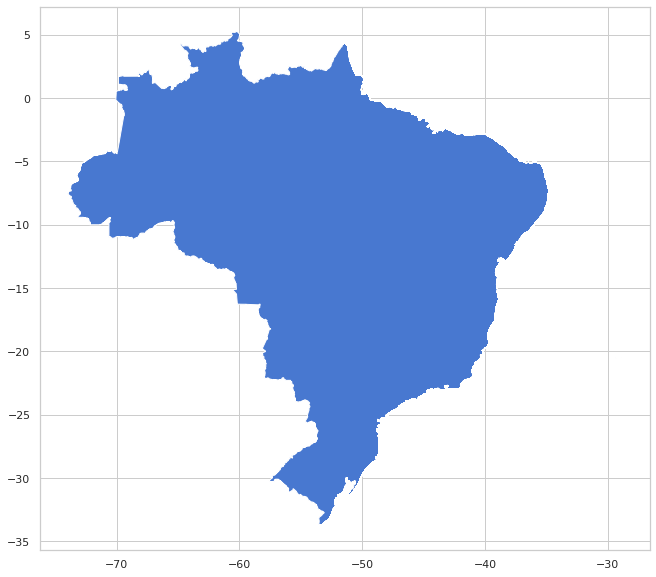

In [66]:
table_num = '0'

country_code = 'BRA'
table_dict = f"{country_code}_adm"
adm_table_name = f"{country_code}_adm{table_num}"
table = admin_shapes['shp_files'][table_dict][adm_table_name]

print(table.crs)
print(table.info())
print(table.head())
table.plot()


## Adm1

epsg:4326
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   ID_0       27 non-null     int64   
 1   ISO        27 non-null     object  
 2   NAME_0     27 non-null     object  
 3   ID_1       27 non-null     int64   
 4   NAME_1     27 non-null     object  
 5   TYPE_1     27 non-null     object  
 6   ENGTYPE_1  27 non-null     object  
 7   NL_NAME_1  0 non-null      object  
 8   VARNAME_1  13 non-null     object  
 9   geometry   27 non-null     geometry
dtypes: geometry(1), int64(2), object(7)
memory usage: 2.2+ KB
None


<AxesSubplot:>

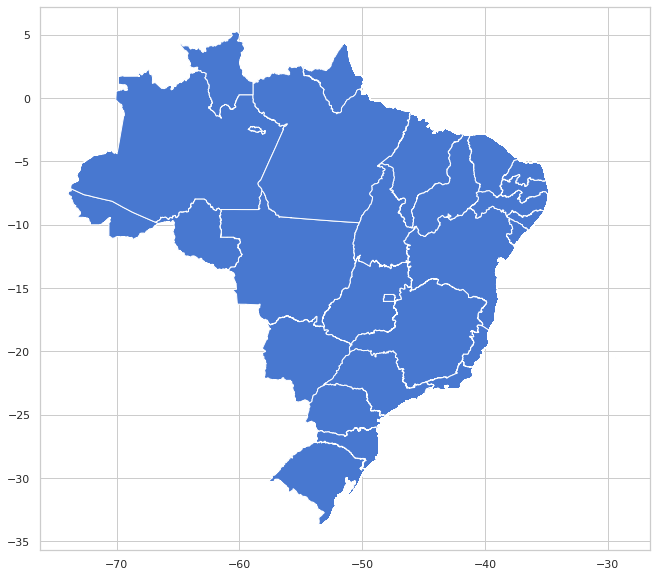

In [68]:
table_num = '1'

country_code = 'BRA'
table_dict = f"{country_code}_adm"
adm_table_name = f"{country_code}_adm{table_num}"
table = admin_shapes['shp_files'][table_dict][adm_table_name]

print(table.crs)
print(table.info())
# print(table.head())
table.plot()


## Adm2

epsg:4326
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 5504 entries, 0 to 5503
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   ID_0       5504 non-null   int64   
 1   ISO        5504 non-null   object  
 2   NAME_0     5504 non-null   object  
 3   ID_1       5504 non-null   int64   
 4   NAME_1     5504 non-null   object  
 5   ID_2       5504 non-null   int64   
 6   NAME_2     5504 non-null   object  
 7   TYPE_2     5502 non-null   object  
 8   ENGTYPE_2  5504 non-null   object  
 9   NL_NAME_2  0 non-null      object  
 10  VARNAME_2  2 non-null      object  
 11  geometry   5504 non-null   geometry
dtypes: geometry(1), int64(3), object(8)
memory usage: 516.1+ KB
None


<AxesSubplot:>

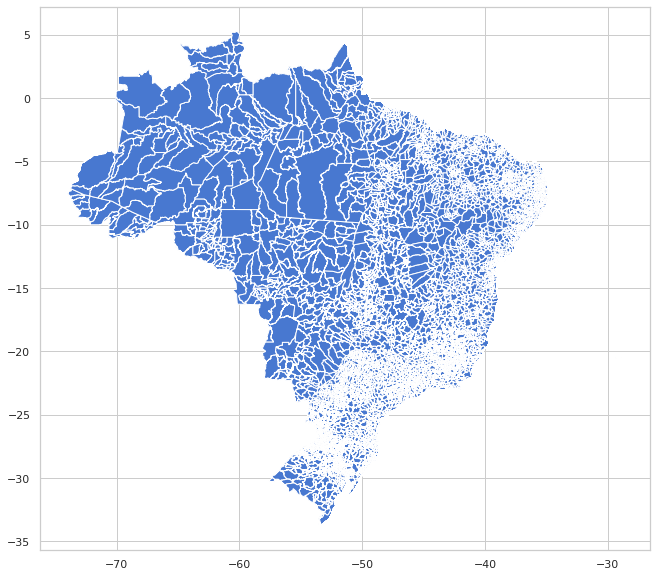

In [69]:
table_num = '2'

country_code = 'BRA'
table_dict = f"{country_code}_adm"
adm_table_name = f"{country_code}_adm{table_num}"
table = admin_shapes['shp_files'][table_dict][adm_table_name]

print(table.crs)
print(table.info())
# print(table.head())
table.plot()


## Adm3

# Import Trip Data

In [50]:
from unidecode import unidecode
'_'.join(unidecode("Vila São José").lower().split())

'vila_sao_jose'

In [51]:
# define participants
participants_list = ["93181b36-6cfb-4b8d-a895-aabef5a6815c",
                     "e59042cb-80f1-472b-80b3-ab69441511ac",
                     "ccc8ea3e-248b-47a3-ad34-89efcbd04ca8",
                     "0ab124d9-edd9-410e-ab72-9fb8ffc7cedd",
                     "a1e660a5-4b0f-4e4d-a631-97ca8264dd5b",
                     "e2dc773b-15e0-4451-8c09-faf5ed644699",
                     "401bfdc2-ee26-4c4e-b350-319cc4499ec2",
                     "9c3e37e8-5b51-463c-8688-4452e0c39dbf",
                     "e8370867-30ce-475a-a444-2bcd1cc321d3",
                     "0563a400-c33a-477f-a656-2a3309d490cb",
                     "f5477b8e-26bb-4e21-9eb1-6d75cbcaa6ce",
                     "d4d5b183-34dc-4402-91f7-46e1a22f4b88",
                     "2e7bd09e-b11b-474f-aa2c-451828c4dc21",
                     "99fed303-77bb-417b-89b5-b70a87bf4a49"]

# define path to token credentials
token_path = os.path.join('..', '..', '..', '..', '..', 'Admin', 'authentication_files', 'uma_api_cred_2021-01-21.json')
print(os.path.exists(token_path))

True


In [74]:
participant = participants_list[6]

# get token to access api
token = get_api_token(token_path)

df_tripevents = get_all_participant_trips(participant, token)
print(df_tripevents.info())

df_trips = parse_trip_legs(df_tripevents)
df_trips["participant_id"] = participant
print(df_trips.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             34 non-null     object
 1   departureTime  34 non-null     object
 2   arrivalTime    34 non-null     object
 3   legs           34 non-null     object
dtypes: object(4)
memory usage: 1.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 34 entries, 0 to 33
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   leg_id               34 non-null     object             
 1   legstart_timestamp   34 non-null     datetime64[ns, UTC]
 2   legend_timestamp     34 non-null     datetime64[ns, UTC]
 3   trip_id              34 non-null     object             
 4   tripstart_timestamp  34 non-null     datetime64[ns, UTC]
 5   tripend_timestamp    34 non-null     datetime64[ns, UT

In [75]:
df_trips.sort_values('legstart_timestamp', ascending=False)

leg_id        legstart_timestamp  \
33  5609e459-3ecc-4ac0-b920-2f59027dcd31 2021-01-29 18:25:05+00:00   
32  80b46c27-c502-4144-9cda-ba67e544bc19 2021-01-29 11:39:35+00:00   
31  f6379252-c51f-4229-9638-2421a4620c30 2021-01-29 10:40:20+00:00   
30  be2d1980-cfb3-4efc-b598-53211a08b733 2021-01-26 21:03:25+00:00   
29  57a3d3c3-1d0e-4100-ad3d-ab9b3559be3d 2021-01-26 04:22:15+00:00   
28  704d867b-e2c3-48f0-a433-3580fc775bfd 2021-01-25 19:18:35+00:00   
27  3daa2a2d-81fc-4ded-9d88-a5fc59fe6707 2021-01-25 16:04:30+00:00   
26  c93343f6-83d3-44c1-b369-6b2a09eb7b40 2021-01-24 21:42:25+00:00   
25  e27a278f-d479-44a2-9e2c-7a4a43735793 2021-01-24 20:01:35+00:00   
24  7f9cf8e6-5d2a-405f-bebb-c9fcdc1a1493 2021-01-20 22:40:50+00:00   
23  5c18249e-2851-4a90-8e32-e42059c80cba 2021-01-20 20:25:50+00:00   
22  fb6540a3-c1b8-4e95-9160-57d1251a466b 2021-01-20 19:46:45+00:00   
21  38ea3439-07cc-421c-9db7-be62017eb512 2021-01-20 16:12:55+00:00   
20  4dd34a5a-80c9-4ae3-abd1-aeb47fe31aaa 2021-01-20 15:21:40+00:00   
19  cd0335d5-d203-46f1-a98e-837857657731 2021-01-20 14:11:25+00:00   
18  120d4a5a-4320-443a-8c85-21229a8b0427 2021-01-19 22:11:10+00:00   
17  156ceefa-f4d5-47b5-9cdd-56386157fc84 2021-01-19 21:36:45+00:00   
16  3f70a826-3b1f-41ee-9023-8956ccef6ce8 2021-01-19 12:25:40+00:00   
15  5f8c62a5-fa51-43e7-ab2f-89198ff6953e 2021-01-19 11:21:45+00:00   
14  c8ff151f-19f5-4334-b8f5-ad577f0c06e5 2021-01-18 20:36:30+00:00   
13  49d11afe-1533-43e4-83e6-b56df80157cc 2021-01-18 11:19:35+00:00   
12  b8c53df9-42ac-4ada-b9e3-64932c56546b 2021-01-17 21:30:15+00:00   
11  3ef51235-4dfe-4e3c-a0bb-afd8371a9fd4 2021-01-17 18:44:40+00:00   
10  747b118f-8fe5-471c-8709-588aa55d2c16 2021-01-16 17:41:30+00:00   
9   4c1e7883-73d0-4a73-8408-d752bfd46295 2021-01-13 16:42:35+00:00   
8   e2ba3f62-77bb-47eb-859b-34fd78aa7702 2021-01-13 16:03:20+00:00   
7   e95c7fb9-208b-4173-8d00-d07918c022d3 2021-01-12 22:21:25+00:00   
6   1f549549-204a-4290-a692-377d29eefc1b 2021-01-12 11:27:35+00:00   
5   f344260e-377b-4bb2-9f51-93f02a4901ca 2021-01-11 21:45:30+00:00   
4   34f3ffb1-f66d-46a7-b37d-6b463e2e7f19 2021-01-11 21:29:40+00:00   
3   5418c0c6-8df5-45d1-86c2-7ca41db62e09 2021-01-11 04:08:15+00:00   
2   241bae10-0841-48af-abf6-90d69bf4ba13 2021-01-09 18:19:40+00:00   
1   4e29a4c1-c771-4b3a-8e61-7a2bf351eff3 2021-01-09 17:51:40+00:00   
0   6c2c033a-edf0-4bc3-972a-3064a1bf6c76 2021-01-09 16:54:40+00:00   

            legend_timestamp                               trip_id  \
33 2021-01-29 18:53:40+00:00  bef8d7c1-3f1a-45c8-8a8f-ef691f6b922b   
32 2021-01-29 12:17:35+00:00  58f823b2-189b-47b1-ad8f-ff1e598f7c96   
31 2021-01-29 11:30:10+00:00  b14174f7-e814-4f30-89c7-7e7706c5ee1d   
30 2021-01-26 22:11:40+00:00  71704eb7-0c66-41d0-95ef-ca1df209aa25   
29 2021-01-26 14:35:05+00:00  097dc5c8-a4d6-471e-bc9a-fc0f74b88e95   
28 2021-01-25 21:45:40+00:00  5bb997bc-32d4-4f34-b690-1aaeb77353eb   
27 2021-01-25 16:46:45+00:00  28fe8a63-14ad-4947-8103-2bf203e29a13   
26 2021-01-25 00:54:30+00:00  5e5389f2-ac83-4dca-b795-08ee96d047d3   
25 2021-01-24 21:32:30+00:00  afc72e3e-6b1e-4094-9560-285c0411c0de   
24 2021-01-20 22:51:15+00:00  111bbc05-5751-4130-beb7-3567e3dcf278   
23 2021-01-20 20:34:30+00:00  9737cf1e-d741-4cc5-8c5c-5143760f3507   
22 2021-01-20 19:54:45+00:00  9e9e3f45-4cb4-46ff-8918-b6c73816bd75   
21 2021-01-20 16:22:35+00:00  d9597f1a-227a-4cb7-99a9-20488525cd10   
20 2021-01-20 15:38:15+00:00  a1d699f5-e2b2-4534-9cb6-3999214737de   
19 2021-01-20 14:29:25+00:00  0abe155c-702e-4bd6-bf43-7e19b3ef3073   
18 2021-01-19 22:56:35+00:00  2f73b59b-b041-46b9-b0a6-bf72ff6d89ed   
17 2021-01-19 21:51:00+00:00  5a3d2b28-9efa-471f-b80d-dd7a0f4b1fe6   
16 2021-01-19 12:35:45+00:00  9b407b43-d0c1-4439-b643-c544a45815dc   
15 2021-01-19 12:04:55+00:00  65468087-1b6d-40ad-9d75-295d411f2470   
14 2021-01-18 21:54:50+00:00  af8dd663-4d8e-4725-bca6-f54f213bfd1e   
13 2021-01-18 12:25:30+00:00  cb994609-9027-4b21-95b6-ab2338d8f000   
12 2021-01-17 22:35:10+00:00  6c130934-a154

In [76]:
start_date = pd.to_datetime('2021-01-25 00:00:00+00:00')
end_date = pd.to_datetime('2021-01-30 00:00:00+00:00')
tripdate_filter = (df_trips['legstart_timestamp'] > start_date) & (df_trips['legstart_timestamp'] < end_date)
df_testrips = df_trips[tripdate_filter]
df_testrips.sort_values('legstart_timestamp', ascending=False, inplace=True)
print(df_testrips.info())
df_testrips.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7 entries, 33 to 27
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   leg_id               7 non-null      object             
 1   legstart_timestamp   7 non-null      datetime64[ns, UTC]
 2   legend_timestamp     7 non-null      datetime64[ns, UTC]
 3   trip_id              7 non-null      object             
 4   tripstart_timestamp  7 non-null      datetime64[ns, UTC]
 5   tripend_timestamp    7 non-null      datetime64[ns, UTC]
 6   trip_duration        7 non-null      int64              
 7   leg_duration         7 non-null      int64              
 8   participant_id       7 non-null      object             
dtypes: datetime64[ns, UTC](4), int64(2), object(3)
memory usage: 560.0+ bytes
None


leg_id        legstart_timestamp  \
33  5609e459-3ecc-4ac0-b920-2f59027dcd31 2021-01-29 18:25:05+00:00   
32  80b46c27-c502-4144-9cda-ba67e544bc19 2021-01-29 11:39:35+00:00   
31  f6379252-c51f-4229-9638-2421a4620c30 2021-01-29 10:40:20+00:00   
30  be2d1980-cfb3-4efc-b598-53211a08b733 2021-01-26 21:03:25+00:00   
29  57a3d3c3-1d0e-4100-ad3d-ab9b3559be3d 2021-01-26 04:22:15+00:00   

            legend_timestamp                               trip_id  \
33 2021-01-29 18:53:40+00:00  bef8d7c1-3f1a-45c8-8a8f-ef691f6b922b   
32 2021-01-29 12:17:35+00:00  58f823b2-189b-47b1-ad8f-ff1e598f7c96   
31 2021-01-29 11:30:10+00:00  b14174f7-e814-4f30-89c7-7e7706c5ee1d   
30 2021-01-26 22:11:40+00:00  71704eb7-0c66-41d0-95ef-ca1df209aa25   
29 2021-01-26 14:35:05+00:00  097dc5c8-a4d6-471e-bc9a-fc0f74b88e95   

         tripstart_timestamp         tripend_timestamp  trip_duration  \
33 2021-01-29 18:25:05+00:00 2021-01-29 18:53:40+00:00           1715   
32 2021-01-29 11:39:35+00:00 2021-01-29 12:17:35+00:00           2280   
31 2021-01-29 10:40:20+00:00 2021-01-29 11:30:10+00:00           2990   
30 2021-01-26 21:03:25+00:00 2021-01-26 22:11:40+00:00           4095   
29 2021-01-26 04:22:15+00:00 2021-01-26 14:35:05+00:00          36770   

    leg_duration                        participant_id  
33         84685  401bfdc2-ee26-4c4e-b350-319cc4499ec2  
32         84120  401bfdc2-ee26-4c4e-b350-319cc4499ec2  
31         83410  401bfdc2-ee26-4c4e-b350-319cc4499ec2  
30         82305  401bfdc2-ee26-4c4e-b350-319cc4499ec2  
29         49630  401bfdc2-ee26-4c4e-b350-319cc4499ec2

### Assess leg Data

In [77]:
df_tripevents['legs'][0]

[{'id': '6c2c033a-edf0-4bc3-972a-3064a1bf6c76',
  'from': {'id': '385e9a91-239d-46ba-a1f4-e8a7b3157b47',
   'placeId': None,
   'place': {'id': '97d17fd9-6b23-4ff7-9d2a-bc22401ea777',
    'latitude': -23.724566910814815,
    'longitude': -46.536152899933334,
    'address': 'R. João de Barros, 415 - Ferrazópolis, São Bernardo do Campo - SP, 09781-230, Brazil',
    'defaultPurpose': 'HOME'},
   'arrivalTime': '2021-01-08T21:21:40Z',
   'departureTime': '2021-01-09T16:54:40Z',
   'purpose': 'HOME'},
  'to': {'id': '53c0e8f6-767e-4b6b-b553-743e247fc3c9',
   'placeId': None,
   'place': {'id': '5a639df9-971e-4968-8196-a13131296c4f',
    'latitude': -23.708868013706898,
    'longitude': -46.547050654827586,
    'address': 'R. Dr. Fláquer, 653 - Centro, São Bernardo do Campo - SP, 09710-180, Brazil',
    'defaultPurpose': 'SHOPPING'},
   'arrivalTime': '2021-01-09T17:14:05Z',
   'departureTime': '2021-01-09T17:51:40Z',
   'purpose': 'SHOPPING'},
  'mode': 'DRIVE',
  'polyline': 'puxoC|a`{GzFn

In [78]:
df_locationevents = get_locations_from_trips(df_testrips, token_path, participant)

print(df_locationevents.info())


get locations for participant_id: 401bfdc2-ee26-4c4e-b350-319cc4499ec2
trip dates:
['2021-01-25', '2021-01-26', '2021-01-29']
fetch locations for date: 2021-01-25
fetch locations for date: 2021-01-26
fetch locations for date: 2021-01-29
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2334 entries, 14 to 2260
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   timestamp  2334 non-null   datetime64[ns, UTC]
 1   type       2334 non-null   object             
 2   payload    2334 non-null   object             
dtypes: datetime64[ns, UTC](1), object(2)
memory usage: 72.9+ KB
None


In [79]:
df_locationevents

timestamp             type  \
14   2021-01-25 03:08:11+00:00  LocationChanged   
17   2021-01-25 03:08:21+00:00  LocationChanged   
28   2021-01-25 03:11:11+00:00  LocationChanged   
29   2021-01-25 03:11:26+00:00  LocationChanged   
31   2021-01-25 03:11:55+00:00  LocationChanged   
...                        ...              ...   
2181 2021-01-30 01:43:58+00:00  LocationChanged   
2182 2021-01-30 01:44:08+00:00  LocationChanged   
2184 2021-01-30 01:44:22+00:00  LocationChanged   
2243 2021-01-30 02:14:47+00:00  LocationChanged   
2260 2021-01-30 02:46:28+00:00  LocationChanged   

                                                payload  
14    {"provider":"gps","latitude":-23.72441879,"lon...  
17    {"provider":"gps","latitude":-23.7244637,"long...  
28    {"provider":"gps","latitude":-23.72446224,"lon...  
29    {"provider":"gps","latitude":-23.72443781,"lon...  
31    {"provider":"gps","latitude":-23.72448396,"lon...  
...                                                 ...  
2181  {"provider":"gps","latitude":-23.72438798,"lon...  
2182  {"provider":"gps","latitude":-23.72440618,"lon...  
2184  {"provider":"gps","latitude":-23.7244446,"long...  
2243  {"provider":"gps","latitude":-23.72448609,"lon...  
2260  {"provider":"gps","latitude":-23.72452571,"lon...  

[2334 rows x 3 columns]

In [80]:
locations_df = prep_data_raw(unpack_payload(df_locationevents))
lon = locations_df['latitude']
lat = locations_df['longitude']

locations_gdf = gpd.GeoDataFrame(locations_df,
                                geometry=gpd.points_from_xy(lon, lat),
                                crs={'init' :'epsg:4326'})
print(locations_gdf.crs)
print(locations_gdf.info())
locations_gdf.head()


+init=epsg:4326 +type=crs
<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2333 entries, 17 to 2260
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   timestamp          2333 non-null   datetime64[ns, UTC]
 1   provider           2333 non-null   object             
 2   latitude           2333 non-null   float64            
 3   longitude          2333 non-null   float64            
 4   accuracy           2333 non-null   float64            
 5   bearing            2333 non-null   float64            
 6   speed              2333 non-null   float64            
 7   time_change        2333 non-null   float64            
 8   speed_change       2332 non-null   float64            
 9   acceleration       2332 non-null   float64            
 10  cumm_acceleration  2332 non-null   float64            
 11  distance           2332 non-null   float64            
 12  cumm_distance

timestamp provider   latitude  longitude   accuracy  \
17 2021-01-25 03:08:21+00:00      gps -23.724464 -46.536085  10.720000   
28 2021-01-25 03:11:11+00:00      gps -23.724462 -46.536134  10.720000   
29 2021-01-25 03:11:26+00:00      gps -23.724438 -46.536185   9.648001   
31 2021-01-25 03:11:55+00:00      gps -23.724484 -46.536138   5.360000   
32 2021-01-25 03:12:40+00:00      gps -23.724530 -46.536136   9.648001   

    bearing  speed  time_change  speed_change  acceleration  \
17      0.0    0.0         10.0           NaN           NaN   
28      0.0    0.0        170.0           0.0           0.0   
29      0.0    0.0         15.0           0.0           0.0   
31      0.0    0.0         29.0           0.0           0.0   
32      0.0    0.0         45.0           0.0           0.0   

    cumm_acceleration  distance  cumm_distance                     geometry  
17                NaN      5.05           5.05  POINT (-23.72446 -46.53608)  
28                0.0      5.86          10.91  POINT (-23.72446 -46.53613)  
29                0.0      7.00          17.91  POINT (-23.72444 -46.53619)  
31                0.0      5.16          23.07  POINT (-23.72448 -46.53614)  
32                0.0      5.73          28.80  POINT (-23.72453 -46.53614)

# Import GTFS Datasets

In [ ]:
root_gtfs_dir = os.path.join('..', '..', '..', 'resources', 'data',
                             'external', 'GTFS', 'latam_gtfs_v002')

cities = ['bogota', 'buenos_aires', 'mexico_city',
          'porto_alegre', 'santiago_deChile', 'sao_paulo']

# files_required = ['agency.txt', 'stops.txt', 'routes.txt', 'shapes.txt']

files_required = ['stops.txt', 'shapes.txt']

In [81]:
from re import sub

gtfs_data = {}

for place in cities:
    
    print(place)
    gtfs_dir = os.path.join(root_gtfs_dir, place, 'GTFS')
    
    gtfs_data[place] = {sub('.txt', "", file):
                        pd.read_csv(os.path.join(gtfs_dir, file))
                        for basepath in os.listdir(gtfs_dir)
                        for file in files_required}
    

bogota
buenos_aires
mexico_city
porto_alegre
santiago_deChile
sao_paulo


### Extract common data fields from each table

Create object for common columns. This will be the first version of standard columns to use.

Analyis is required to determine if more columns are required.

name: `standard_columns`

In [82]:

city = 'sao_paulo'

# create new standard object
gtfs_data['standard_columns'] = {}


# check common folders for each file type
for file in [file.replace('.txt','') for file in files_required]:
    print(file)
    print(gtfs_data[city].keys())
    print("=====")
    
#     # ensure that key is in 
#     if file in gtfs_data[city]:
        
#         print([gtfs_data[city][file].columns
#                for city in gtfs_data.keys()])
        
    file_cols_per_city = [list(gtfs_data[city][file].columns)
                          for city in cities]
    
    print(file_cols_per_city)
    print("=====")
#     print(table_cols)
#     print(set.intersection(*[set(list) for list in table_cols]))
    
    
    # create set of columns that are common to all files
    gtfs_data['standard_columns'][sub('.txt', "", file)] = list(set.intersection(*[set(list)
                                                                                   for list in file_cols_per_city]))
    
#     print(gtfs_data.keys())
    print(gtfs_data['standard_columns'])
    
    print("\n\n")

stops
dict_keys(['stops', 'shapes'])
=====
[['stop_id', 'stop_code', ' stop_name', 'stop_desc', 'stop_lat', 'stop_lon', 'stop_url', 'wheelchair_boarding'], ['stop_id', 'stop_code', 'stop_name', 'stop_desc', 'stop_lat', 'stop_lon', 'zone_id', 'stop_url', 'location_type', 'parent_station', 'stop_timezone', 'wheelchair_boarding'], ['stop_id', 'stop_code', 'stop_name', 'stop_desc', 'stop_lat', 'stop_lon', 'zone_id', 'stop_url', 'location_type', 'parent_station', 'wheelchair_boarding'], ['stop_id', 'stop_code', 'stop_name', 'stop_desc', 'stop_lat', 'stop_lon'], ['stop_id', 'stop_code', 'stop_name', 'stop_lat', 'stop_lon', 'stop_url'], ['stop_id', 'stop_name', 'stop_desc', 'stop_lat', 'stop_lon']]
=====
{'stops': ['stop_id', 'stop_lat', 'stop_lon']}



shapes
dict_keys(['stops', 'shapes'])
=====
[['shape_id', 'shape_pt_lat', 'shape_pt_lon', 'shape_pt_sequence'], ['shape_id', 'shape_pt_lat', 'shape_pt_lon', 'shape_pt_sequence', 'shape_dist_traveled'], ['shape_id', 'shape_pt_sequence', 'shape_

In [83]:
for file in [file.replace('.txt','') for file in files_required]:
    
    print(file)
#     print(gtfs_data['standard_columns'])
    standard_columns = gtfs_data['standard_columns'][file]
    print(standard_columns)
#     print(gtfs_data[city]['standard_columns'])
#     print("\n\n")

stops
['stop_id', 'stop_lat', 'stop_lon']
shapes
['shape_pt_lon', 'shape_id', 'shape_pt_sequence', 'shape_pt_lat']


# Coordinate Reference Systems (CRS) and Coordinate Projection Systems (CPS)


- [Brazil projections](https://epsg.io/?q=Brazil)
    - Sao Paulo EPSG: 31983
    - Porto Algere EPSG: 31982
- [Argentina projections](https://epsg.io/?q=Argentina)
    - Buenos Aires EPSG: 32721
- [South Africa projections](https://epsg.io/?q=south+africa)
    - Cape Town: 2048
    - Johannesburg: 2052
    - Durban: 2054
- [Chile projections](https://epsg.io/?q=chile)
    - Santiago de Chile EPSG: 9155
- [Mexico projections](https://epsg.io/?q=mexico)
    - Mexico City EPSG: 6369
- [Colombia projectins](https://epsg.io/?q=Colombia)
    - Bogota EPSG: 3116
    
```json
{"EPSG": {
	"sao_paulo": 31983
	"porto_algere": 31982
	"buenos_aires": 32721
	"cape_town": 2048
	"johannesburg": 2052
	"durban": 2054
	"santiago_deChile": 9155
	"mexico_city": 6369
	"bogota": 3116
    }
}
```



In [84]:
epsg_dict = {
    "sao_paulo": 31983,
    "porto_alegre": 31982,
    "buenos_aires": 32721,
    "cape_town": 2048,
    "johannesburg": 2052,
    "durban": 2054,
    "santiago_deChile": 9155,
    "mexico_city": 6369,
    "bogota": 3116,
    }


In [85]:
gtfs_data['epsg_code'] = {key:val for key, val in epsg_dict.items()
                          if key in cities}

# add WGS84 projection
gtfs_data['epsg_code']['WGS84'] = 4326

print(gtfs_data['epsg_code'])

{'sao_paulo': 31983, 'porto_alegre': 31982, 'buenos_aires': 32721, 'santiago_deChile': 9155, 'mexico_city': 6369, 'bogota': 3116, 'WGS84': 4326}


# Parse required data from gtfs

In [86]:
gtfs_data['transit_buffers'] = {}

print(gtfs_data['transit_buffers'])

{}


## Create Points and buffers

In [87]:
file = 'stops'
for city in cities:
    
    # 
    print(city)
    columns = gtfs_data['standard_columns'][file]
    temp_df = gtfs_data[city][file][columns]
    
    # create point features
    lon = temp_df['stop_lat']
    lat = temp_df['stop_lon']
    temp_gdf = gpd.GeoDataFrame(temp_df,
                                geometry=gpd.points_from_xy(lon, lat),
                                crs={'init' :'epsg:4326'})
    
    # reproject spatial data
    temp_gdf['city'] = city
    epsg_code = gtfs_data['epsg_code'][city]
    temp_gdf = temp_gdf.to_crs(epsg=epsg_code)
    
    # update file in dictionary
    gtfs_data[city][file] = temp_gdf
    
    # create buffers around points
    temp_gdf['buffer_50m'] = temp_gdf.buffer(50)
    gtfs_data['transit_buffers'][file] = temp_gdf.dissolve('city')['buffer_50m']
    
    
    print(gtfs_data['transit_buffers'][file].crs)
    print(gtfs_data['transit_buffers'][file])
    print("\n\n")

bogota
None
city
bogota    POLYGON ((2765470.727 -9153669.689, 2765470.48...
Name: buffer_50m, dtype: geometry



buenos_aires
None
city
buenos_aires    POLYGON ((1782545.034 3296366.167, 1782544.794...
Name: buffer_50m, dtype: geometry



mexico_city
None
city
mexico_city    POLYGON EMPTY
Name: buffer_50m, dtype: geometry



porto_alegre
None
city
porto_alegre    POLYGON ((1949929.732 4122260.586, 1949929.492...
Name: buffer_50m, dtype: geometry



santiago_deChile
None
city
santiago_deChile    POLYGON ((1750666.533 1783254.636, 1750666.293...
Name: buffer_50m, dtype: geometry



sao_paulo
None
city
sao_paulo    POLYGON ((2137430.566 4603277.916, 2137430.325...
Name: buffer_50m, dtype: geometry





## Create Routes

In [88]:
from shapely.geometry import LineString
file = 'shapes'
for city in cities:
    
    # 
    print(city)
    columns = gtfs_data['standard_columns'][file]
    temp_df = gtfs_data[city][file][columns]
    
    
    # create line features
    lon = temp_df['shape_pt_lat']
    lat = temp_df['shape_pt_lon']
    print("creating points...")
    temp_gdf = gpd.GeoDataFrame(temp_df,
                                geometry=gpd.points_from_xy(lon, lat))
    print("creating points complete")
    
    print("creating lines...")
    temp_gdf = temp_gdf.groupby(['shape_id'])['geometry'].apply(lambda x: LineString(x.tolist()))
    print("creating lines complete")
    
    # re initialise projection
    temp_gdf = gpd.GeoDataFrame(temp_gdf, geometry='geometry',
                                crs={'init' :'epsg:4326'})
    
    # reproject spatial data
    temp_gdf['city'] = city
    epsg_code = gtfs_data['epsg_code'][city]
    temp_gdf = temp_gdf.to_crs(epsg=epsg_code)
    
    # update file in dictionary
    gtfs_data[city][file] = temp_gdf
    
    
    # create buffers around lines
    print("creating buffer...")
    temp_gdf['buffer_20m'] = temp_gdf.buffer(20)
    print("creating buffer complete")
    
#     print("consolidating buffer features...")
#     temp_gdf = temp_gdf.dissolve('city')['buffer_20m']
#     print("consolidating buffer features complete")
    
    
    # reset projection to initial coordinate system
    epsg_code = gtfs_data['epsg_code']['WGS84']
    gtfs_data['transit_buffers'][file] = temp_gdf.to_crs(epsg=epsg_code)
    
    
    print(gtfs_data['transit_buffers'][file].crs)
    print(gtfs_data['transit_buffers'][file].info())
    print("\n\n")

bogota
creating points...
creating points complete
creating lines...
creating lines complete
creating buffer...
creating buffer complete
epsg:4326
<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 663 entries, SP_1005 to SP_995
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   geometry    663 non-null    geometry
 1   city        663 non-null    object  
 2   buffer_20m  663 non-null    geometry
dtypes: geometry(2), object(1)
memory usage: 20.7+ KB
None



buenos_aires
creating points...
creating points complete
creating lines...
creating lines complete
creating buffer...
creating buffer complete
epsg:4326
<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2099 entries, 120 to 67221
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   geometry    2099 non-null   geometry
 1   city        2099 non-null   object  
 2   buffer_20m  2099 non-n

# Device Events Transit Stops Analysis

## Determine City for Device Events

In [ ]:
gtfs_data['transit_buffers'][file]

In [ ]:
stops_newcrs.plot()

In [ ]:
stops_newcrs['buffer_100m'].plot()

# Transit Route Analyis

In [ ]:
line_newcrs['buffer_100m'] = line_newcrs['geometry'].buffer(100)
print(line_newcrs.info())
line_newcrs.head()

In [ ]:
line_newcrs.plot()

In [ ]:
line_newcrs['buffer_100m'].plot()